# Import Libraries

In [43]:
import numpy as np
import pandas as pd  
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import PIL
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Load & Preprocess Data

In [29]:
data_dir = "data/train"#directory of the  train data
test_dir = "data/test"#directory of the  test data

height,width=180,180#Size of the image
batch_size=32
train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height,width),# resize images after they are read from folder
  batch_size=batch_size)#Size of the batches of data to load at a time

Found 8386 files belonging to 7 classes.
Using 6709 files for training.


# KFold

In [30]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height,width),
  batch_size=batch_size)

Found 8386 files belonging to 7 classes.
Using 1677 files for validation.


In [44]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,#directory of the  test data
    shuffle = True,
    seed=123,
    image_size =(height,width),
    batch_size =batch_size  
)

Found 2201 files belonging to 7 classes.


In [47]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Convert datasets to numpy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)

In [48]:
class_names=train_dataset.class_names
print(class_names)

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


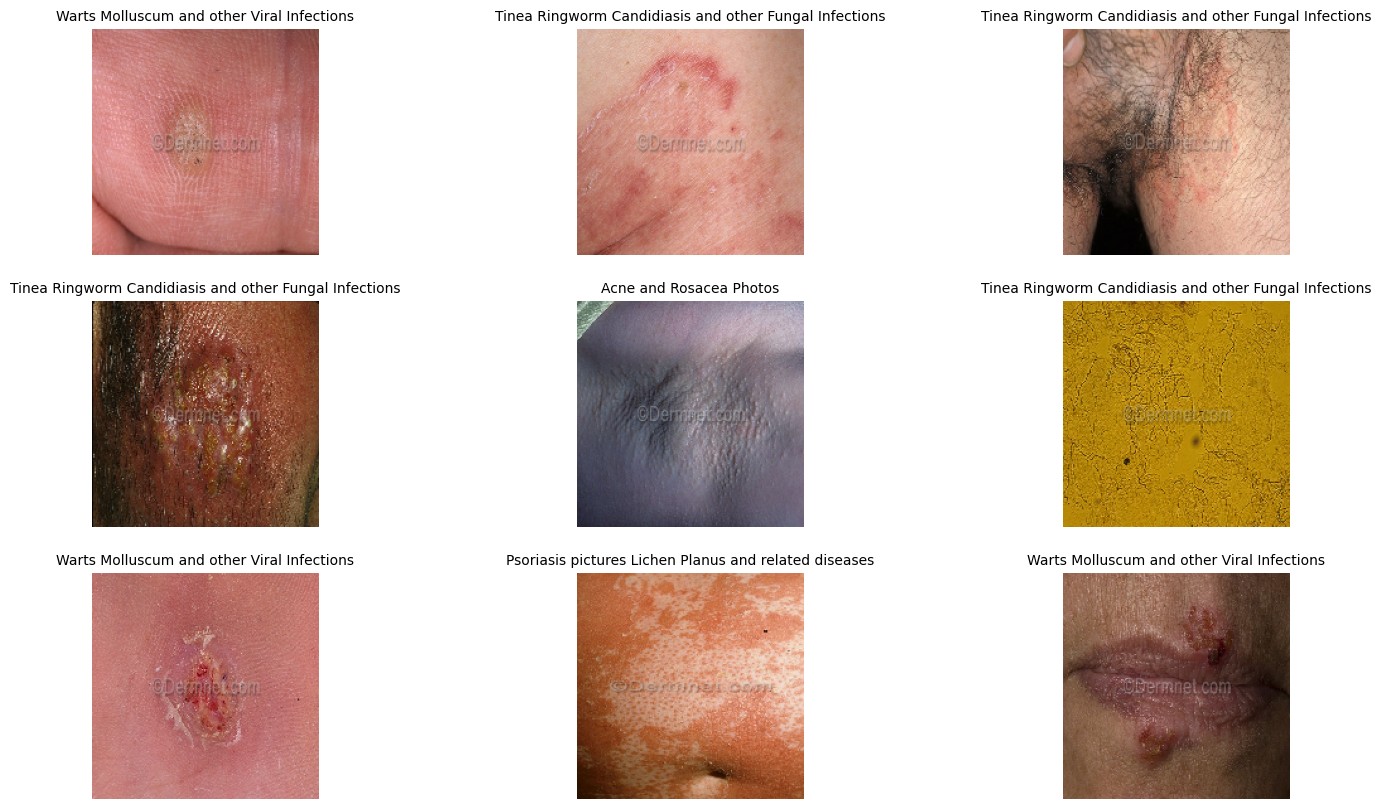

In [49]:
plt.figure(figsize = (10,10))#setting the size images in plot only
for images, labels in train_dataset.take(1):#looping through the dataset
   for i in range(9):
     ax = plt.subplot(3,3,i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(class_names[labels[i]],fontsize = 10)
     plt.subplots_adjust(right =1.5)   
     plt.axis("off")

In [34]:
location = Path('data/train')
array = []
for folders in location.glob("*"):
    row = {}
    row["disease"] = folders.name.replace("Photos", "")
    list = os.listdir(folders) 
    countFiles = len(list)
    row["count"] =countFiles
    array.append(row)  
df=pd.DataFrame(array) 
print(df)

                                             disease  count
0                                  Acne and Rosacea     840
1  Actinic Keratosis Basal Cell Carcinoma and oth...   1149
2                                            Eczema    1235
3  Psoriasis pictures Lichen Planus and related d...   1405
4       Seborrheic Keratoses and other Benign Tumors   1371
5  Tinea Ringworm Candidiasis and other Fungal In...   1300
6         Warts Molluscum and other Viral Infections   1086


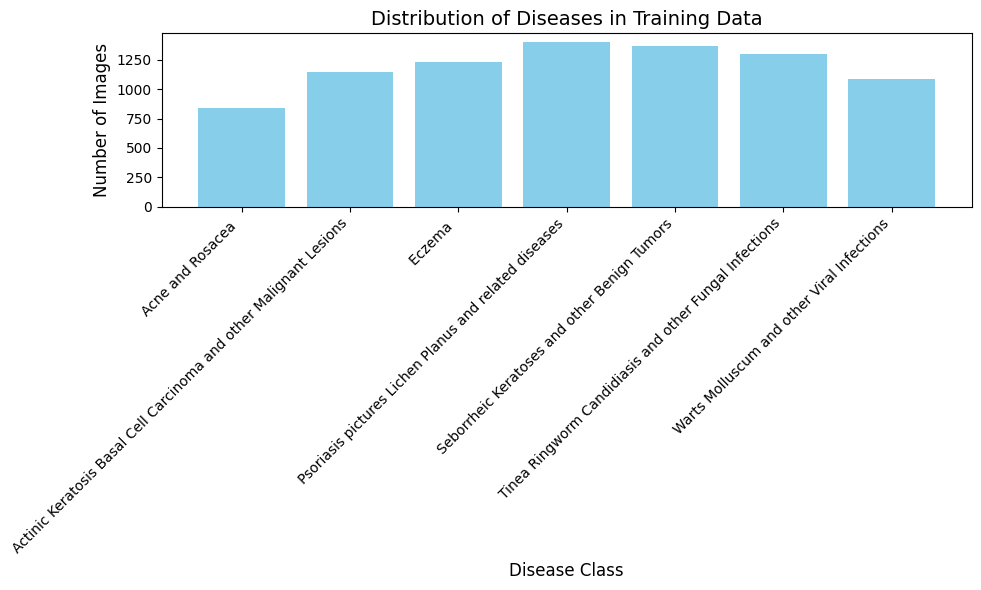

In [35]:
# Step 1: Plotting a Bar Chart
plt.figure(figsize=(10, 6))

# Step 2: Create the bar chart
plt.bar(df["disease"], df["count"], color='skyblue')

# Step 3: Adding labels and title
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Diseases in Training Data', fontsize=14)

# Step 4: Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Step 5: Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

# Load Model + Add Layers

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a variable to track the best validation accuracy
best_val_accuracy = 0
best_model = None  # To store the best model
best_history = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Training fold {fold + 1}/5")

    # Split data into train and validation for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create the model
    model= Sequential()

    resnet_model= tf.keras.applications.ResNet50(include_top=False,
                      input_shape=(180,180,3),
                      pooling='avg',classes=7,
                      weights='imagenet')

    for layer in resnet_model.layers:
            layer.trainable=False#freezing layers of the resnet model

    model.add(resnet_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))#output layer
    

    # Compile the model (if not already compiled)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Set up callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # Train the model on the current fold
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Fold {fold + 1} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        model.save("best_model.h5")
        print(f"New best model saved with accuracy: {val_accuracy}")

Training fold 1/5
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 572ms/step - accuracy: 0.2935 - loss: 5.2551 - val_accuracy: 0.4426 - val_loss: 3.5475
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 545ms/step - accuracy: 0.4506 - loss: 3.2639 - val_accuracy: 0.4985 - val_loss: 2.5594
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 549ms/step - accuracy: 0.5406 - loss: 2.2980 - val_accuracy: 0.5127 - val_loss: 2.0600
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 93s 553ms/step - accuracy: 0.5976 - loss: 1.7698 - val_accuracy: 0.5194 - val_loss: 1.7861
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 549ms/step - accuracy: 0.6474 - loss: 1.4290 - val_accuracy: 0.5432 - val_loss: 1.6959
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 91s 545ms/step - accuracy: 0.6880 - loss: 1.2394 - val_accuracy: 0.5380 - val_loss: 1.6612
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 548ms/step - accuracy: 0.7151 - loss: 1.1017 - val_accuracy: 0.5551 - val_loss: 1.6396
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 92s 549ms/step - accurac

Fold 1 - Validation Loss: 1.7818561792373657, Validation Accuracy: 0.5521609783172607
New best model saved with accuracy: 0.5521609783172607
Training fold 2/5
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 95s 544ms/step - accuracy: 0.2947 - loss: 5.2037 - val_accuracy: 0.4598 - val_loss: 3.4593
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 539ms/step - accuracy: 0.4577 - loss: 3.2846 - val_accuracy: 0.5291 - val_loss: 2.5156
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 537ms/step - accuracy: 0.5405 - loss: 2.3091 - val_accuracy: 0.5246 - val_loss: 2.0090
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 536ms/step - accuracy: 0.5995 - loss: 1.7694 - val_accuracy: 0.5417 - val_loss: 1.7479
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 537ms/step - accuracy: 0.6512 - loss: 1.4260 - val_accuracy: 0.5559 - val_loss: 1.6296
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 535ms/step - accuracy: 0.7021 - loss: 1.1978 - val_accuracy: 0.5507 - val_loss: 1.5848
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 90s 534ms/step 

Fold 4 - Validation Loss: 1.745658040046692, Validation Accuracy: 0.5633382797241211
New best model saved with accuracy: 0.5633382797241211
Training fold 5/5
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 97s 554ms/step - accuracy: 0.2845 - loss: 5.2303 - val_accuracy: 0.4683 - val_loss: 3.4704
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 531ms/step - accuracy: 0.4557 - loss: 3.2629 - val_accuracy: 0.5242 - val_loss: 2.5066
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 528ms/step - accuracy: 0.5452 - loss: 2.2700 - val_accuracy: 0.5257 - val_loss: 2.0207
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 528ms/step - accuracy: 0.6092 - loss: 1.7196 - val_accuracy: 0.5556 - val_loss: 1.7560
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 88s 527ms/step - accuracy: 0.6560 - loss: 1.3890 - val_accuracy: 0.5436 - val_loss: 1.6339
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 528ms/step - accuracy: 0.7176 - loss: 1.1769 - val_accuracy: 0.5533 - val_loss: 1.5947
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 89s 529ms/step -

In [57]:

# Get training and validation accuracy and loss
history_dict = best_history['history']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


TypeError: 'NoneType' object is not subscriptable

In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,780,167 (94.53 MB)

 Trainable params: 1,187,335 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [41]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_names),
    y=class_names
)

class_weights_dict = dict(enumerate(class_weights))

# Training

In [42]:
epochs=100
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,class_weight=class_weights_dict,callbacks=[early_stopping])

Epoch 1/100
210/210 ━━━━━━━━━━━━━━━━━━━━ 115s 531ms/step - accuracy: 0.2368 - loss: 5.6555 - val_accuracy: 0.4144 - val_loss: 4.7396
Epoch 2/100
 49/210 ━━━━━━━━━━━━━━━━━━━━ 2:39 990ms/step - accuracy: 0.3657 - loss: 4.9692

KeyboardInterrupt: 

# Model Evaluation

In [3]:
#plotting the learning curves training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.axis(ymin=0.4,ymax=1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

NameError: name 'history' is not defined

In [37]:
model.save("./model_v5.keras");

In [121]:
#testing model accuracy with the testing set(unbiased)
score =model.evaluate(test_dataset)
print('Test accuracy:', score[1])

69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 433ms/step - accuracy: 0.5954 - loss: 1.7187
Test accuracy: 0.5801908373832703


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


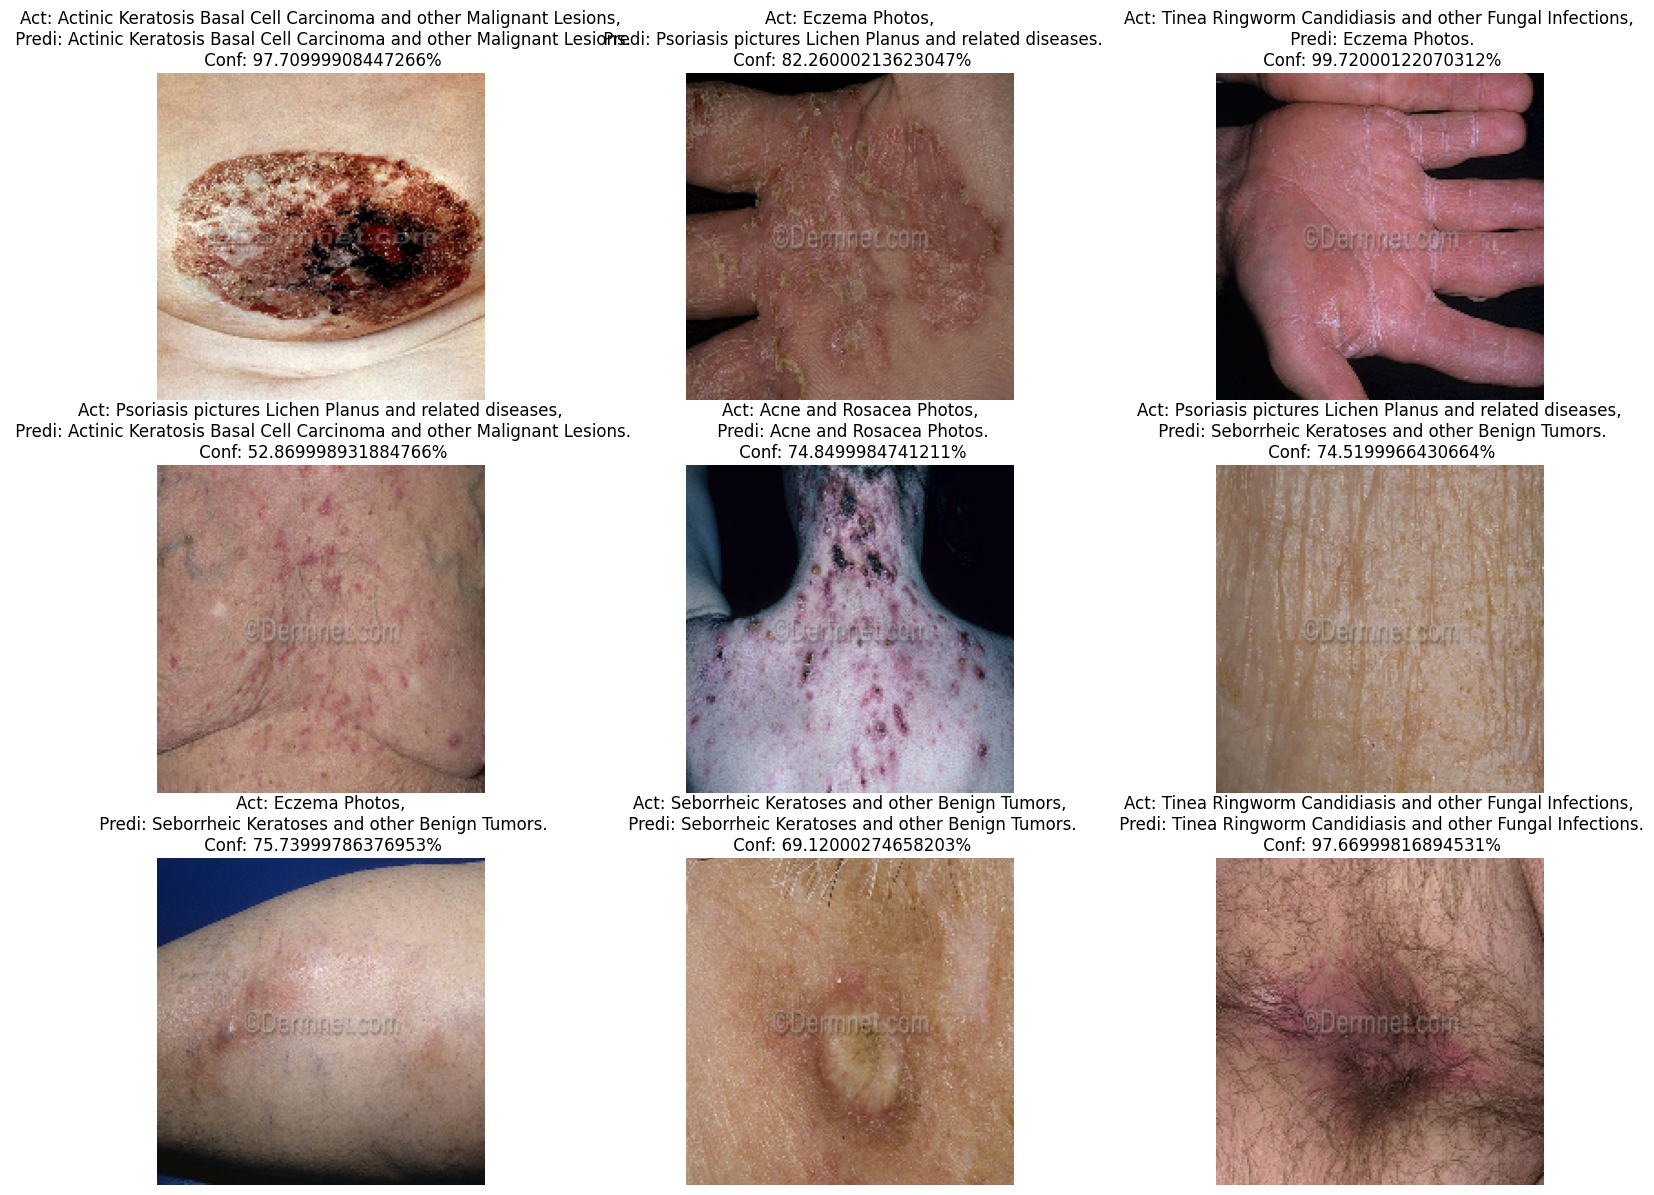

In [122]:
#predicting multiple images
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.subplots_adjust(right =2,top=1.5)
        plt.title(f"Act: {actual_class},\n Predi: {predicted_class}.\n Conf: {confidence}%")
        plt.axis("off")